In [1]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint

In [2]:
import numpy as np
import ray
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tune_sklearn import TuneSearchCV
from xgboost import XGBRegressor
import pandas as pd
from pathlib import Path
import time
import pickle
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt 

In [3]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    return {'r2': round(r2, 4), 'MAE': round(mean_absolute_error, 4), 'MSE': round(mse, 4), 'RMSE': round(np.sqrt(mse), 4), "explained_variance": round(explained_variance, 4)}

In [71]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [73]:
%reload_ext memory_profiler

In [5]:
# !/home/dev/Desktop/Work/uncoverml/venv/bin/ray start --head --port=6379 --num-cpus=1

In [6]:
# !/home/dev/Desktop/Work/uncoverml/venv/bin/ray --version

In [7]:
ray.__version__

'1.1.0'

In [8]:
# !/home/dev/Desktop/Work/uncoverml/venv/bin/ray stop

In [9]:
ray.init(num_cpus=20, num_gpus=4)

2021-02-08 14:32:44,804	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.11.161',
 'raylet_ip_address': '192.168.11.161',
 'redis_address': '192.168.11.161:6379',
 'object_store_address': '/tmp/ray/session_2021-02-08_14-32-44_288352_77843/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-08_14-32-44_288352_77843/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-08_14-32-44_288352_77843',
 'metrics_export_port': 53568,
 'node_id': '7caab62b98d38e037972e31c106010e35a4f3a75'}

In [15]:
ray.shutdown()

In [84]:
# read the csv file created

input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
]


features_to_use = ["target","Grav_lane_clip","clim_PTA_albers","be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata","3dem_mag1_fin","ceno_euc_aust1","be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata","Thorium_2016","dem_fill","relief_elev_focalrange1000m_3s","LATITUDE_GRID1_clip","LOC_distance_to_coast","clim_EPA_albers","be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata","LONGITUDE_GRID1_clip","si_geol1","3dem_mag2","clim_WDA_albers","Dose_2016","Clim_Prescott_LindaGregory","Potassium_2016","mrvbf_9","Rad2016K_Th","be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata","clim_RSM_albers","3dem_mag0.fin","s2-dpca-85m_1","water-85m_3","saga_wetSM_85_reprojected"]

parameters = {
    "objective": ["reg:squarederror"],
    "gamma":[0],
    "eval_metric": ["rmse", "mae","logloss","auc"],
    "n_estimators":[500, 700],
    "max_depth":[3, 15],
    "subsample":[0.8, 1],
    "min_child_weight":[10, 20],
    "learning_rate":[0.01, 0.2],
    "colsample_bytree":[0.5,1]
}

model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist',n_jobs=-1,eval_metric=None)

xgb_tune_search = TuneSearchCV(
    model,
    parameters,

    search_optimization="bayesian",
    n_jobs=-1,
    n_trials=300,
    early_stopping=False,
    scoring='r2',

    verbose=1,
    return_train_score=True,
    loggers=["csv"],
    use_gpu=True
)

for input_file in input_files:

    print("Input file: ",input_file)
    df = pd.read_csv(input_file).astype('float32')
    df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
    df = df[features_to_use]
    y_train = df['target']
    X_train = df.drop("target",axis=1)
    
    start = time.time()
    xgb_tune_search.fit(X_train, y_train)
    end = time.time()
    print("Tune Fit Time:", end - start)  
    
    fileObj = open('xgb_tune_search'+input_file.stem+'.pkl', 'wb')
    pickle.dump(xgb_tune_search,fileObj)
    fileObj.close()
    

2021-02-08 09:04:14,218	INFO tune.py:448 -- Total run time: 11975.73 seconds (11975.57 seconds for the tuning loop).


Tune Fit Time: 12009.920269966125


## Setup Bayesian search with reporting OOS results 

In [14]:
input_files = [
    (Path("../data/formated_dataset.csv"),Path("../data/formated_oos_dataset.csv")),
    (Path("../data/scaler_df.csv"),Path("../data/scaler_oos_df.csv")),
    (Path("../data/quantile_df.csv"),Path("../data/quantile_oos_df.csv"))
]


features_to_use = ["target","Grav_lane_clip","clim_PTA_albers","be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata","3dem_mag1_fin","ceno_euc_aust1","be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata","Thorium_2016","dem_fill","relief_elev_focalrange1000m_3s","LATITUDE_GRID1_clip","LOC_distance_to_coast","clim_EPA_albers","be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata","LONGITUDE_GRID1_clip","si_geol1","3dem_mag2","clim_WDA_albers","Dose_2016","Clim_Prescott_LindaGregory","Potassium_2016","mrvbf_9","Rad2016K_Th","be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata","clim_RSM_albers","3dem_mag0.fin","s2-dpca-85m_1","water-85m_3","saga_wetSM_85_reprojected"]

input_file,input_oos_file = input_files[0]

# read input dataset
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y_train = df['target']
X_train = df.drop("target",axis=1)

# read oos dataset
print("Input oos file: ",input_oos_file)
df = pd.read_csv(input_oos_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y_oos = df['target']
X_oos = df.drop("target",axis=1)

# read previous results
with open('xgb_tune_search'+input_file.stem+'.pkl', "rb") as f:
    xgb_tune_search = pickle.load(f)
best_model = xgb_tune_search.best_estimator_

y_train_pred = best_model.predict(X_train)
results_oss = regression_results(y_train, y_train_pred)
print("Training results:",results_oss)

y_oos_pred = best_model.predict(X_oos)
results_oss = regression_results(y_oos, y_oos_pred)
print("OOS results:",results_oss)
print()
print()


Input file:  ../data/formated_dataset.csv
Input oos file:  ../data/formated_oos_dataset.csv
Training results: {'r2': 0.9736, 'MAE': 0.0308, 'MSE': 0.0046, 'RMSE': 0.068, 'explained_variance': 0.9736}
OOS results: {'r2': 0.7567, 'MAE': 0.6192, 'MSE': 1.1911, 'RMSE': 1.0914, 'explained_variance': 0.7617}




In [37]:
experiments = {}
total_experiments = len(xgb_tune_search.cv_results_["params"])

for i in range(total_experiments):
    experiments[i] = {}
    experiments[i]["test_score"] = {}
    experiments[i]["train_score"] = {}
    for key in xgb_tune_search.cv_results_.keys():
        if "param_" not in key:
            if "test" in key:
                experiments[i]["test_score"][key] = xgb_tune_search.cv_results_[key][i]
            elif "train" in key:
                experiments[i]["train_score"][key] = xgb_tune_search.cv_results_[key][i]
            else:
                experiments[i][key] = xgb_tune_search.cv_results_[key][i]
        

In [46]:
# read the csv file created
input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv")
]

input_oos_files = [
    Path("../data/formated_oos_dataset.csv"),
    Path("../data/scaler_oos_df.csv"),
    Path("../data/quantile_oos_df.csv")
]

features_to_use = ["target","Grav_lane_clip","clim_PTA_albers","be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata","3dem_mag1_fin","ceno_euc_aust1","be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata","Thorium_2016","dem_fill","relief_elev_focalrange1000m_3s","LATITUDE_GRID1_clip","LOC_distance_to_coast","clim_EPA_albers","be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata","LONGITUDE_GRID1_clip","si_geol1","3dem_mag2","clim_WDA_albers","Dose_2016","Clim_Prescott_LindaGregory","Potassium_2016","mrvbf_9","Rad2016K_Th","be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata","clim_RSM_albers","3dem_mag0.fin","s2-dpca-85m_1","water-85m_3","saga_wetSM_85_reprojected"]

input_file = input_files[0]
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y = df['target']
X = df.drop("target",axis=1)

input_oos_file = input_oos_files[0]
print("Input oos file: ",input_oos_file)
df = pd.read_csv(input_oos_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y_oos = df['target']
X_oos = df.drop("target",axis=1)




Input file:  ../data/formated_dataset.csv
Input oos file:  ../data/formated_oos_dataset.csv


In [ ]:
experiments[0]

In [84]:
%%time

print("len",len(experiments))
for experiment in experiments:
    print(experiment)
    xgbr = XGBRegressor(tree_method='gpu_hist',n_jobs=-1,verbosity=1,**experiments[experiment]["params"])
    xgbr.fit(X, y)
    y_pred = xgbr.predict(X_oos)
    oos_score = r2_score(y_oos, y_pred)
    experiments[experiment]["oos_score"] = oos_score
    

len 300
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [86]:
fileObj = open('experiment_oos.pkl', 'wb')
pickle.dump(experiments,fileObj)
fileObj.close()

In [67]:
from sklearn.metrics import mean_squared_error, r2_score
# - cross validataion 
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X, y, cv=kfold )
print("K-fold CV scores: ", kf_cv_scores)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

oos_score = {}
oos_score["oos_score"]

for i, oos_kf_score in enumerate(kf_cv_scores):
    score_tag = "split"+str(i)+"_oos_score"
    oos_score["oos_score"][score_tag] = oos_kf_score
    

ypred = xgbr.predict(X_oos)
mse = mean_squared_error(y_oos, ypred)
r2 = r2_score(y_oos, ypred)
print("R2: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))


K-fold CV scores:  [0.90798124 0.90807436 0.90581892 0.90241524 0.90520274]
K-fold CV average score: 0.91
R2: 0.79
MSE: 1.04
RMSE: 1.02


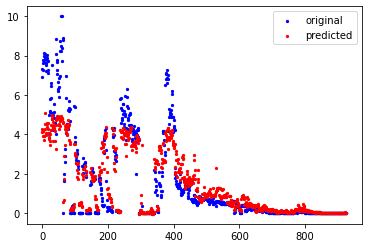

In [65]:
x_ax = range(len(y_oos))
plt.scatter(x_ax, y_oos, s=5, color="blue", label="original")
plt.scatter(x_ax, ypred, s=5, color="red", label="predicted")
plt.legend()
plt.show()

In [63]:
## Fit with cross validation
start_time = time.time()
# xgb_tune_search.best_estimator_.fit(X_test, y_test)   
y_pred = xgb_tune_search.best_estimator_.predict(X_test)
duration = (time.time() - start_time)/60       
print("results: ",regression_results(y_test, y_pred))
print("XGBOOST HyperParameter Tuning  %s minutes ---" % + duration)

results:  {'r2': 0.9092, 'MAE': 0.0609, 'MSE': 0.0076, 'RMSE': 0.0874, 'explained_variance': 0.9092}
XGBOOST HyperParameter Tuning  0.003015621503194173 minutes ---


## OOS Testing

In [43]:
# read the csv file created
input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv")
]

input_oos_files = [
    Path("../data/formated_oos_dataset.csv"),
    Path("../data/scaler_oos_df.csv"),
    Path("../data/quantile_oos_df.csv")
]

features_to_use = ["target","Grav_lane_clip","clim_PTA_albers","be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata","3dem_mag1_fin","ceno_euc_aust1","be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata","Thorium_2016","dem_fill","relief_elev_focalrange1000m_3s","LATITUDE_GRID1_clip","LOC_distance_to_coast","clim_EPA_albers","be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata","LONGITUDE_GRID1_clip","si_geol1","3dem_mag2","clim_WDA_albers","Dose_2016","Clim_Prescott_LindaGregory","Potassium_2016","mrvbf_9","Rad2016K_Th","be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata","clim_RSM_albers","3dem_mag0.fin","s2-dpca-85m_1","water-85m_3","saga_wetSM_85_reprojected"]

input_file = input_files[0]
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y = df['target']
X = df.drop("target",axis=1)

input_oos_file = input_oos_files[0]
print("Input oos file: ",input_oos_file)
df = pd.read_csv(input_oos_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
df = df[features_to_use]
y_oos = df['target']
X_oos = df.drop("target",axis=1)




Input file:  ../data/formated_dataset.csv
Input oos file:  ../data/formated_oos_dataset.csv


In [71]:
# OOS sample dataset
# need to itrate over all the models that are selected!!
best_model = xgb_tune_search.best_estimator_
y_pred = best_model.predict(X_oos)
results_oss = regression_results(y_oos, y_pred)
print("OOS results:",results_oss)



OOS results:
{'r2': 0.7721, 'MAE': 0.5843, 'MSE': 1.1158, 'RMSE': 1.0563, 'explained_variance': 0.7766}


In [72]:
# OOS sample dataset
# need to itrate over all the models that are selected!!
best_model = xgb_tune_search.best_estimator_
y_pred = best_model.predict(X)
results_oss = regression_results(y, y_pred)
print("Training results:")
print(results_oss)

Training results:
{'r2': 0.9831, 'MAE': 0.0259, 'MSE': 0.003, 'RMSE': 0.0544, 'explained_variance': 0.9831}


In [55]:
xgb_tune_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.01521019979455194,
             max_delta_step=0, max_depth=15, min_child_weight=20, missing=nan,
             monotone_constraints='()', n_estimators=544, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1.0, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)